# Identifying Duplicate Questions

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color = sns.color_palette()
%matplotlib inline
matplotlib.style.use('ggplot')

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# my own module
from conf.configure import Configure

In [3]:
print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
train.csv                     63.0MB
sample_submission.csv         22.0MB
README.md                     0.0MB
test.csv                      314.0MB


In [4]:
train = pd.read_csv(Configure.original_train_path)
test = pd.read_csv(Configure.original_test_path)

In [7]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


训练集总数:	404290
测试集总数:	2345796
重复率:		0.369197853026
问题总数:		537933
出现多次的问题:	111780


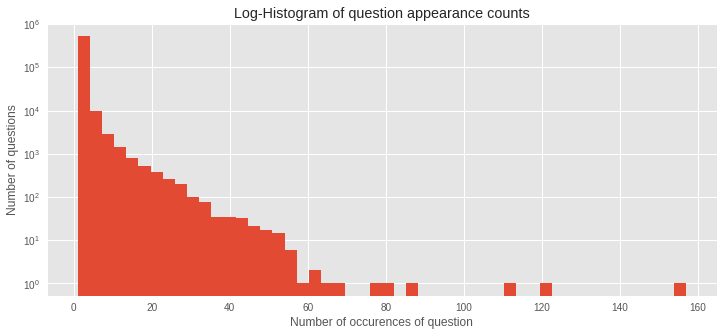

In [35]:
print u'训练集总数:\t{}'.format(train.shape[0])
print u'测试集总数:\t{}'.format(test.shape[0])

print u'重复率:\t\t{}'.format(1.*sum(train['is_duplicate']) / train.shape[0]) 
q_ids = train['qid1'].values.tolist() + train['qid2'].values.tolist()
print u'问题总数:\t\t{}'.format(len(set(q_ids)))
q_ids = pd.Series(q_ids)
print u'出现多次的问题:\t{}'.format(np.sum(q_ids.value_counts() > 1))

plt.figure(figsize=(12, 5))
plt.yscale('log', nonposy='clip')
plt.hist(q_ids.value_counts(), bins=50)
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

## 利用平均值测试提交结果

In [37]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

train_X,test_X, train_y, test_y = train_test_split(train,  
                                                   train['is_duplicate'],  
                                                   test_size = 0.2,  
                                                   random_state = 0)

mean_prob = train_y.mean()
print u'线下验证集 log loss: {}'.format(log_loss(test_y, [mean_prob] * test_X.shape[0]))

线下验证集 log loss: 0.658649340907


In [34]:
df_test = pd.read_csv(Configure.original_test_path)
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': mean_prob})
sub.to_csv('../result/mean_prob_submission.csv.gz', index=False, compression='gzip')

线下验证集 log loss: 0.658649340907, LB Score: 0.55410, PB Score: 0.55525, 线下线上相差较大!说明数据分布存在不一致! 注意线下验证集的划分.

## Question Text analysis

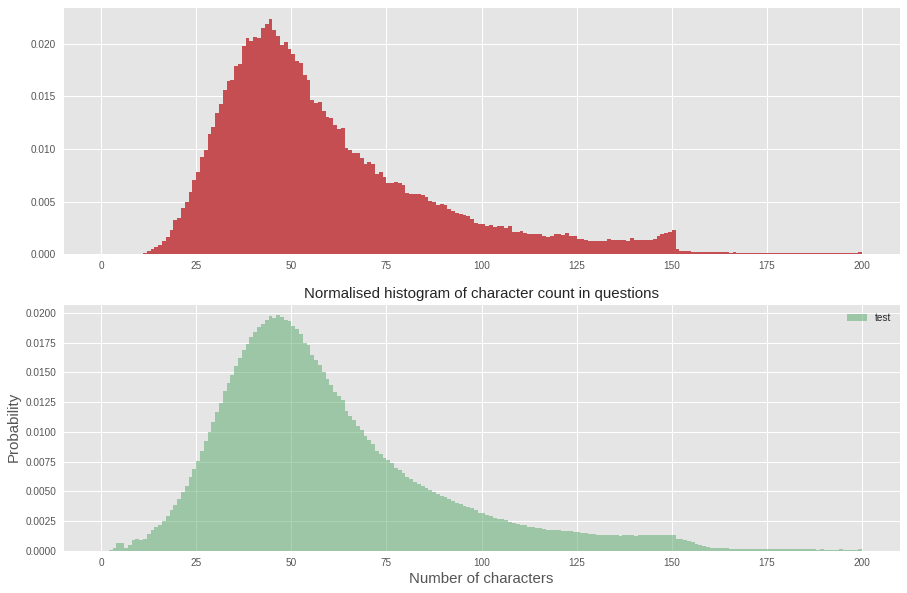

In [45]:
# 问题的字符串长度
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)

train_qs_len = train_qs.apply(len)
test_qs_len = test_qs.apply(len)

plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.hist(train_qs_len, bins=200, range=[0, 200], color=color[2], normed=True, label='train')
plt.subplot(212)
plt.hist(test_qs_len, bins=200, range=[0, 200], color=color[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

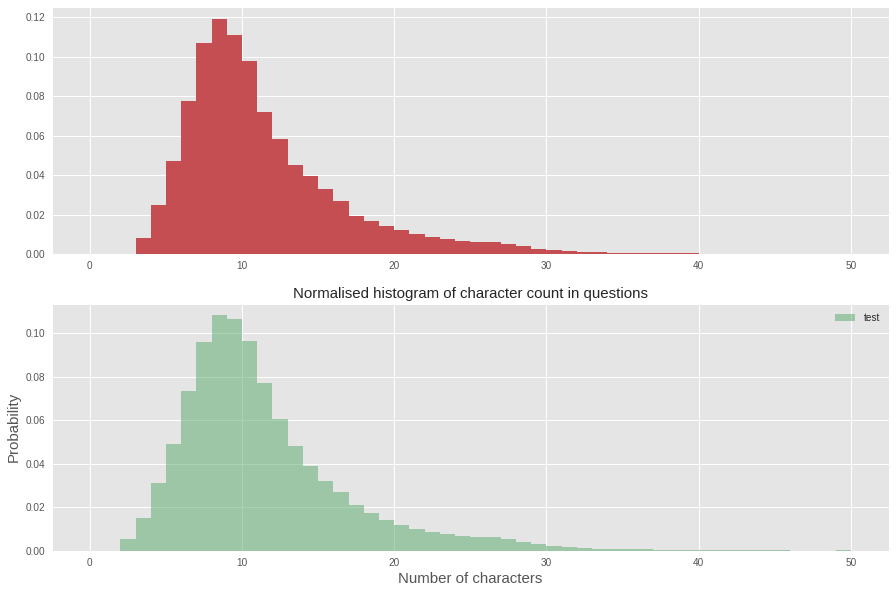

In [44]:
# 问题的单词数目
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)

train_qs_len = train_qs.apply(lambda data: len(data.split(' ')))
test_qs_len = test_qs.apply(lambda data: len(data.split(' ')))

plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.hist(train_qs_len, bins=50, range=[0, 50], color=color[2], normed=True, label='train')
plt.subplot(212)
plt.hist(test_qs_len, bins=50, range=[0, 50], color=color[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

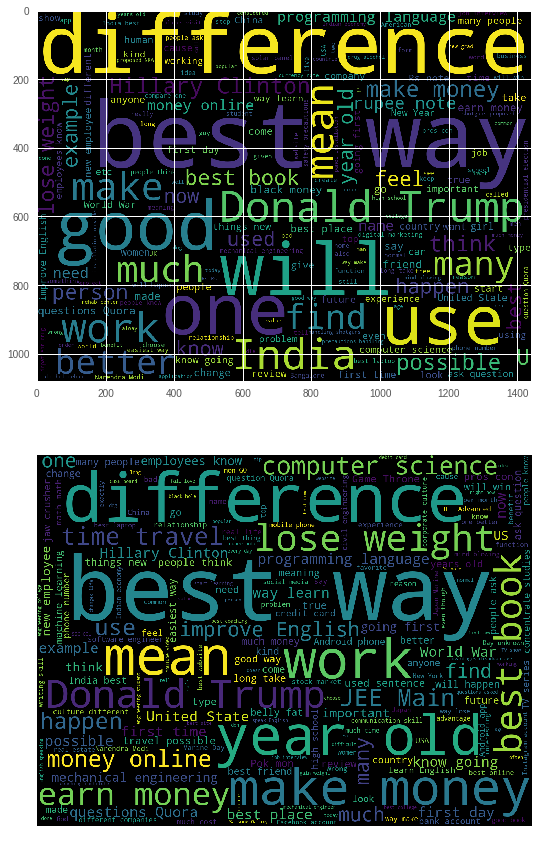

In [48]:
# 词频统计
from wordcloud import WordCloud

plt.figure(figsize=(20, 15))
plt.subplot(211)
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs))
plt.imshow(cloud)
plt.subplot(212)
cloud = WordCloud(width=1440, height=1080).generate(" ".join(test_qs))
plt.imshow(cloud)
plt.axis('off')
plt.show()